<a href="https://colab.research.google.com/github/hida0/ESAA-2022-2/blob/HW/Week05_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 캐글 필사
[Titanic Top 4% with ensemble modeling | Kaggle](https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook)

 I choosed the Titanic competition which is a good way to introduce feature engineering and ensemble modeling. Firstly, I will display some feature analyses then ill focus on the feature engineering. Last part **concerns modeling and predicting the survival** on the Titanic **using an voting procedure**.

## 1. Load Data and Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.3f}'.format # 지수표현 없애기

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/ESAA/data/train.csv")
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [ ]:
test = pd.read_csv("/content/drive/MyDrive/ESAA/data/test.csv")
print(test.shape)
test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.500,0,0,330911,7.829,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000,1,0,363272,7.000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.000,0,0,240276,9.688,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.000,0,0,315154,8.662,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000,1,1,3101298,12.287,NaN,S


## 2. Load and Check data
### 2-1. Outlier detection
- 사분위수의 IQR을 벗어나는 이상치를 제거하는 함수를 생성한다.
- 숫자형 칼럼에 대해 함수를 적용하면 10개의 행이 제거된다. 
- 28, 89, 342번째 행은 'Fare'가 지나치게 높으며, 나머지 7개의 행은 'SibSp'가 지나치게 높다.

In [ ]:
from collections import Counter
def detect_outliers(df, n, features):
    outlier_indices=[]

    for col in features:
        Q1 = np.percentile(df[col], 25) # 1st quantile(25%)
        Q3 = np.percentile(df[col], 75) # 3rd quantile(75%)
        IQR = Q3-Q1
        outlier_step = 1.5*IQR
        
        outlier_list_col = df[ (df[col]<Q1-outlier_step) | (df[col]>Q3+outlier_step) ].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices) # 중복된 데이터가 저장된 배열을 인자로 넘기면 각 원소가 몇 번씩 나오는지가 저장된 객체 반환
    multiple_outliers = list(k for k, v in outlier_indices.items() if v>n) # 지정한 n회보다 많이 나오는 index를 반환

    return multiple_outliers

In [ ]:
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
Outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [ ]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.000,3,2,19950,263.000,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.000,3,2,19950,263.000,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.550,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.550,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.550,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.550,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.000,3,2,19950,263.000,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.550,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.550,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.550,NaN,S


In [ ]:
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

## 2. Load and Check data
### 2-2. Joining train data and test data set
- `pd.concat`을 이용하여 학습 데이터와 훈련 데이터를 합쳐 하나의 데이터로 만든다.

In [ ]:
data = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

## 2. Load and Check data
### 2-3. Check for null and missing values
- 결측치를 np.nan으로 채우고 개수를 확인해보면 Age, Cabin 칼럼에서 결측치가 많다는 것을 알 수 있다. 
- test data에는 타겟 변수인 Survived 칼럼이 존재하지 않으므로 test data의 행의 개수만큼 결측치가 나타난다.

In [ ]:
data = data.fillna(np.nan)
data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


In [ ]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [ ]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000,881.000,881.000,711.000,881.000,881.000,881.000
mean,446.714,0.386,2.308,29.732,0.455,0.363,31.122
std,256.617,0.487,0.835,14.548,0.872,0.792,47.996
min,1.000,0.000,1.000,0.420,0.000,0.000,0.000
25%,226.000,0.000,2.000,20.250,0.000,0.000,7.896
50%,448.000,0.000,3.000,28.000,0.000,0.000,14.454
75%,668.000,1.000,3.000,38.000,1.000,0.000,30.500
max,891.000,1.000,3.000,80.000,5.000,6.000,512.329


## 3. Feature analysis
### 3-1. Numerical values
- 타겟 변수인 Survived와의 상관관계를 살펴보면, 오직 Fare 변수만 유효한 상관관계가 있는 것처럼 보인다.
- 좀 더 정확한 분석을 위해 타겟 변수 Survied와 대상 피처들의 관계를 더 자세하게 살펴본다.

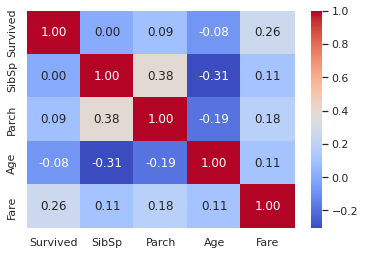

In [ ]:
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

#### 1) SibSp
- 혼자 온 손님(0)이나 두명 이하의 동승자가 있는 경우(1, 2)에 생존한 사람이 더 많다.
- SibSp의 수가 많을수록 살아남을 확률이 적어진다는 것을 알 수 있다.

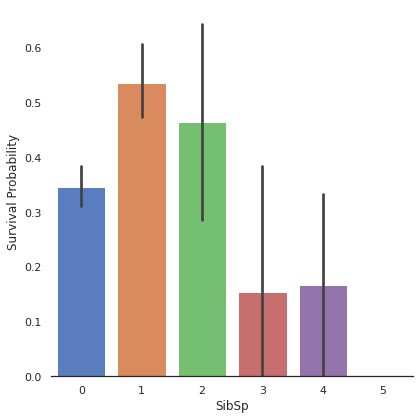

In [ ]:
g = sns.factorplot(x='SibSp', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

#### 2) Parch
- Parch가 1, 2일때에 혼자(0)인 가족이나, 중간(3, 4) 또는 대가족(5, 6)보다 살아남을 확률이 더 높다는 것을 알 수 있다.
- Parch가 3인 경우, 표준편차가 매우 크므로 주목할 필요가 있다.

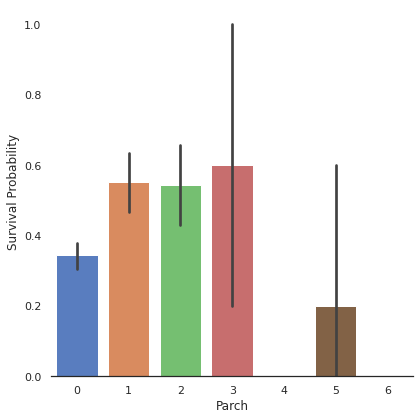

In [ ]:
g = sns.factorplot(x='Parch', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

#### 3) Age
- 나이에 따른 생존 여부의 분포를 그려보면 꼬리가 긴 분포 형태로, 가우스 분포와 유사하다.
- 생존 분포에서 살펴봤을때, 젊은 나이에서 peak를 가지며, 나이가 많아질수록 생존자가 적어진다.
- 생존한 사람의 분포에 아주 낮은 0세에서 5세의 연령대에서 peak를 가진다.
- Survived와 Age의 상관계수가 높지는 않지만, 살아남을 가능성이 더 높은 연령대가 존재한다는 것을 알 수 있다.

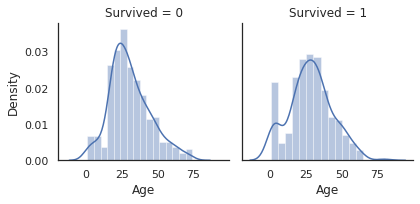

In [ ]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

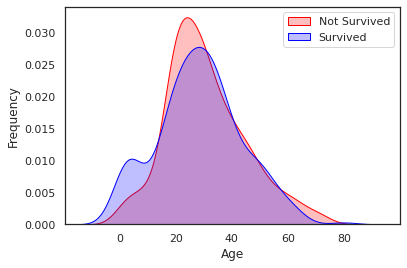

In [ ]:
g = sns.kdeplot(train['Age'][ (train['Survived']==0) & (train['Age'].notnull()) ], color='Red', shade=True)
g = sns.kdeplot(train['Age'][ (train['Survived']==1) & (train['Age'].notnull()) ], ax=g, color='Blue', shade=True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

#### 4) Fare
- Fare 칼럼에 하나의 결측치가 존재한다. 이 결측치를 Fare의 중간값으로 대체한다.
- Fare 칼럼의 분포가 매우 왜곡되어 있다. 
- 모형에서 크기가 조절되더라도 과대추정을 유발할 수 있다.
- `np.log`를 이용해 로그변환을 수행하여 분포의 왜곡 정도를 줄인다.
- 왜곡 정도가 4.51에서 0.57로 감소했음을 확인할 수 있다.

In [ ]:
data['Fare'].isnull().sum()

1

In [ ]:
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

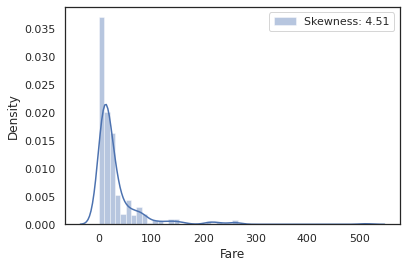

In [ ]:
g = sns.distplot(data['Fare'], color='b', label='Skewness: %.2f'%(data['Fare'].skew()))
g = g.legend(loc='best')

In [ ]:
data['Fare'] = data['Fare'].map(lambda i: np.log(i) if i>0 else 0)

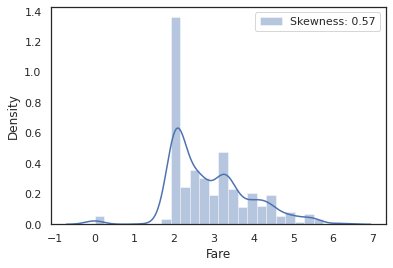

In [ ]:
g = sns.distplot(data['Fare'], color='b', label='Skewness: %.2f'%(data['Fare'].skew()))
g = g.legend(loc='best')

## 3. Feature analysis
### 3-2. Categorical values
#### 1) Sex
- 남자가 여자보다 생존할 확률이 매우 적다는 것을 알 수 있다.
- 따라서 생존 여부를 예측하는데 Sex 칼럼이 매우 중요한 역할을 할 것이라고 판단된다.

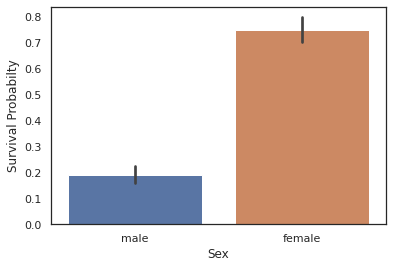

In [ ]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel("Survival Probabilty")

In [ ]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.748
male,0.191


#### 2) Pclass
- Pclass별로 생존 확률을 살펴보면 1일때 가장 높고, 다음으로 2, 3에서 가장 낮다.
- 각 Pclass 내에서 Sex 별로 나누어 살펴보면, 역시 여자의 생존 확률이 남자보다 높게 나타난다.

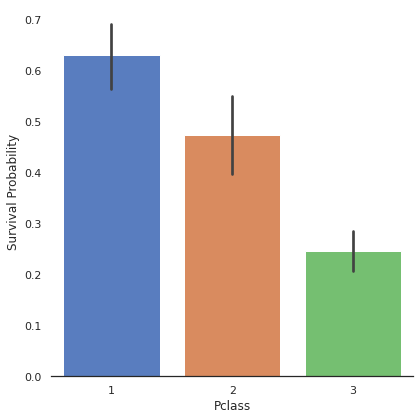

In [ ]:
g = sns.factorplot(x='Pclass', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

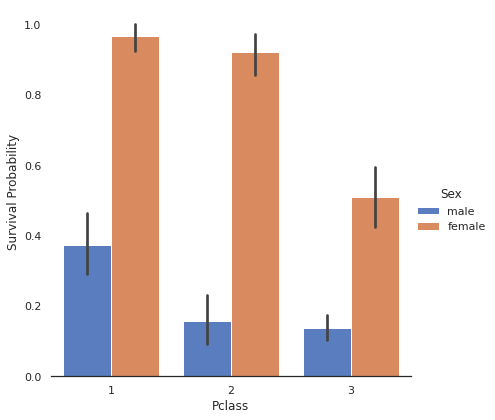

In [ ]:
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

#### 3) Embarked
- Embarked 칼럼에는 2개의 결측치가 존재한다. 이 결측치를 Embarked 칼럼에서 가장 많은 수인 'S'로 대체한다.
- Embarked가 'C'일 때 생존 확률이 제일 높으므로, Cherbourg의 손님이 살아남을 가능성이 높다는 것을 알 수 있다.
- Pclass와 연관지어 일등석에 탑승한 손님 중에 Cherbourg에서 온 손님의 비율이 높을 것이라고 추측할 수 있다.

In [ ]:
data['Embarked'].isnull().sum()

2

In [ ]:
data['Embarked'] = data['Embarked'].fillna('S')

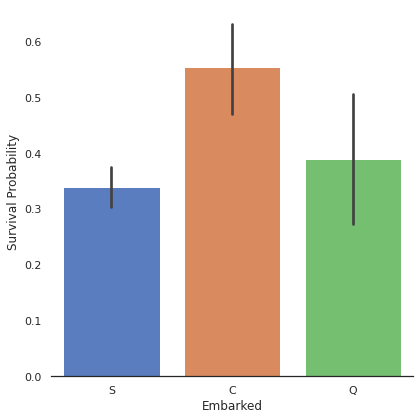

In [ ]:
g = sns.factorplot(x='Embarked', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

#### 3) Pclass vs Embarked
- 앞선 추측을 확인해보기 위해 두 칼럼의 분포를 비교한다.
- Embarked의 'S', 'C', 'Q' 각각에 대해 Pclass의 분포를 그린다.
- 예상대로 Cherbourg에서 온 손님의 Pclass가 일등석인 경우가 많다.
- 나머지 카테고리인 'S'와 'C'에서는 3등석의 경우가 가장 많다.

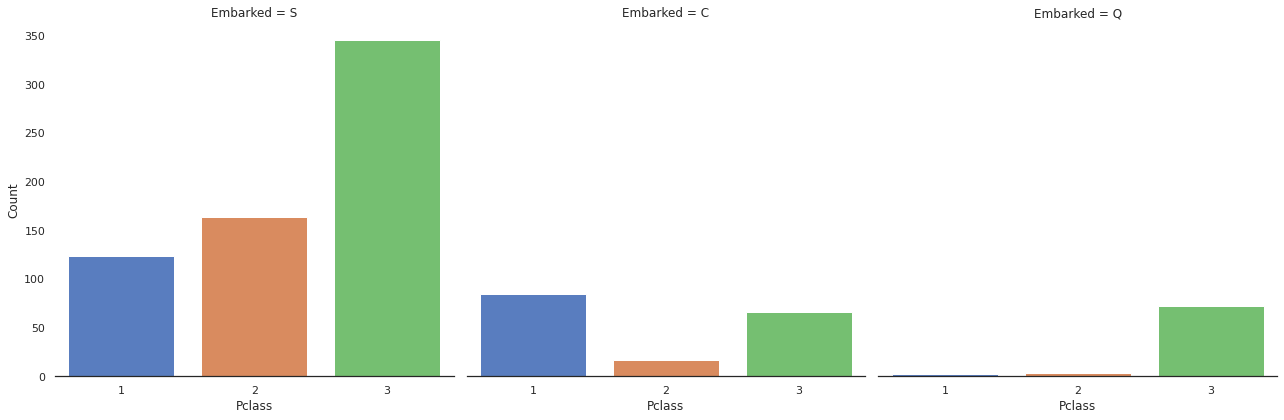

In [ ]:
g = sns.factorplot('Pclass', col='Embarked', data=train, kind='count', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels("Count")

## 4. Filling Missing Values
### 4-1. Age
- Age 칼럼은 256개의 결측치를 갖는다.
- 어린이와 같은 생존 확률이 높은 특정한 연령대가 있으므로, 연령의 특성을 유지하면서 결측치를 처리해야 한다.
- 이를 위해 먼저 Age 칼럼과 (Sex, Parch, Pclass and SibSp) 칼럼 중에 가장  상관관계가 높은 칼럼을 찾는다.
---
- Age 분포는 Sex의 남자와 여자에서 비슷하므로, 성별은 나이를 예측하는데 중요하지 않아보인다.
- Pclss의 1등석에서 3등석보다 나이가 많다.
- Parch가 많을수록, 즉 부모/자녀가 많을수록 나이가 많다. 
- SibSp가 많을수록, 즉 형제/자매가 많을수록 나이가 어리다.

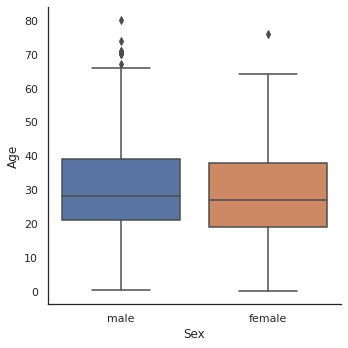

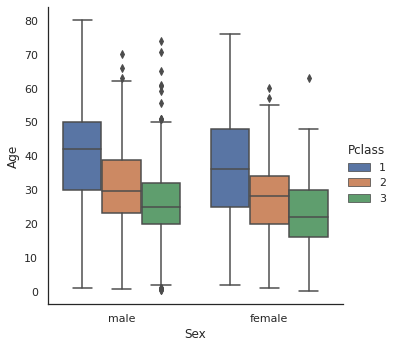

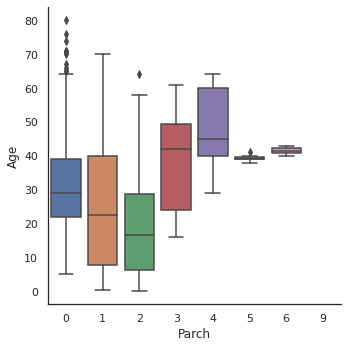

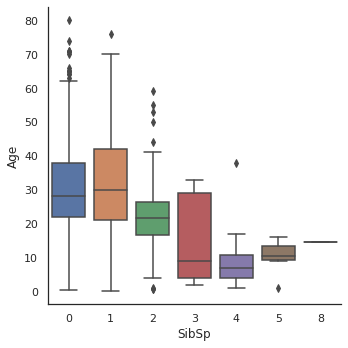

In [ ]:
g = sns.factorplot(y='Age', x='Sex', data=data, kind='box')
g = sns.factorplot(y='Age', x='Sex', hue='Pclass', data=data, kind='box')
g = sns.factorplot(y='Age', x='Parch', data=data, kind='box')
g = sns.factorplot(y='Age', x='SibSp', data=data, kind='box')

## 4. Filling Missing Values
### 4-1. Age
- 정확한 수치를 구하기 위해 Sex 칼럼을 남자는 0, 여자는 1로 변환한다.
- 그 후에 `corr( )`을 이용하여 Age 칼럼과 (Sex, Parch, Pclass and SibSp)의 상관계수를 구한다.

In [ ]:
data['Sex'] = data['Sex'].map({'male':0, 'female':1})

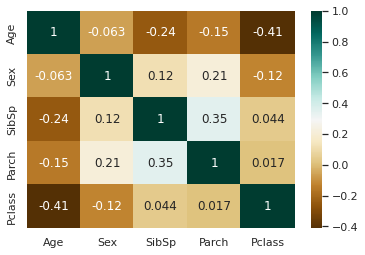

In [ ]:
g = sns.heatmap(data[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

## 4. Filling Missing Values
### 4-1. Age
- Age와 Sex의 상관계수가 매우 낮다.
- Age와 SibSp, Parch, Pclass는 음의 상관계수를 갖는다.
- 따라서 Age의 결측치를 SibSp, Parch, Pclass에 따른 유사한 행의 나이 중위값으로 처리한다.

In [ ]:
data['Age'][data['Age'].isnull()].index

Int64Index([   5,   17,   19,   26,   27,   28,   30,   31,   35,   41,
            ...
            1246, 1247, 1261, 1263, 1265, 1289, 1291, 1294, 1297, 1298],
           dtype='int64', length=256)

In [ ]:
# Age가 결측치인 행의 index 추출
index_NaN_age = list(data['Age'][data['Age'].isnull()].index) 

for i in index_NaN_age:
    age_med = data['Age'].median()
    age_pred = data['Age'][ ( (data['SibSp']==data.iloc[i]['SibSp']) & (data['Parch']==data.iloc[i]['Parch']) & (data['Pclass']==data.iloc[i]['Pclass']) ) ].median()
    if not np.isnan(age_pred):
        data['Age'].iloc[i] = age_pred # 결측치가 아니면 새롭게 구한 유사 중위값으로 대체
    else:
        data['Age'].iloc[i] = age_med # 결측치라면 전체 Age의 중위값으로 대체

## 4. Filling Missing Values
### 4-1. Age
- 생존 여부에 따른 Age의 중위값이 매우 유사해졌다.
- 생존 여부에 따른 Age의 분포를 바이올린 그래프로 그려보니, Survived가 1일때 Age가 낮은 쪽에서 peak를 갖는다.
- 여전히 나이가 어린 손님들의 생존 확률이 더 높게 나타난다는 것을 알 수 있다.

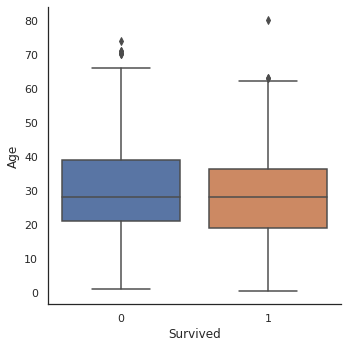

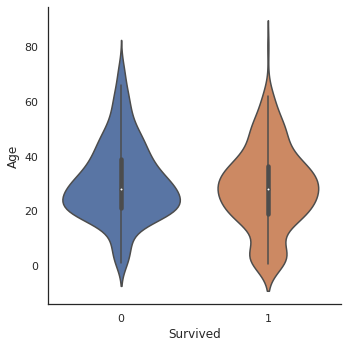

In [ ]:
g = sns.factorplot(x='Survived', y='Age', data=train, kind='box')
g = sns.factorplot(x='Survived', y='Age', data=train, kind='violin')

## 5. Feature engineering
### 5-1. Name/Title
- 승객의 이름 칼럼을 분석한다.
- Mr/Mrs/Miss 등으로 구별되는 것이 대피하는 동안 영향을 주었는지 확인하기 위해 이름 피처를 Title 칼럼으로 생성하고, 모델에 추가한다.


In [ ]:
data['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [ ]:
data_title = [i.split(",")[1].split(".")[0].strip() for i in data['Name']]
data['Title'] = pd.Series(data_title)
data['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

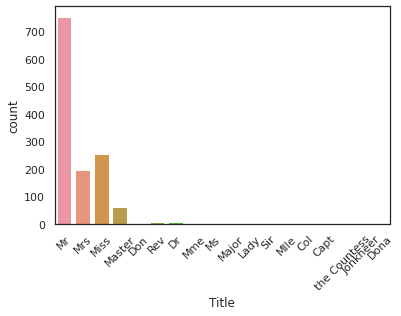

In [ ]:
g = sns.countplot(x='Title', data=data)
g = plt.setp(g.get_xticklabels(), rotation=45)

## 5. Feature engineering
### 5-1. Name/Title
- 17개의 Title 카테고리가 생성된다. 그 중 대부분의 개수가 아주 작으므로 4개의 그룹으로 그룹화한다.
- 여자를 의미하는 이름을 가진 사람들의 생존 확률이 더 높은 것을 알 수 있다.

In [ ]:
data['Title'] = data['Title'].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].map({'Master': 0, 'Miss': 1, 'Ms': 1, 'Mme': 1, 'Mlle':1, 'Mrs':1, 'Mr':2, "Rare":3})
data['Title'] = data['Title'].astype(int)

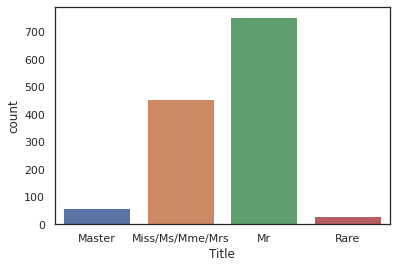

In [ ]:
g = sns.countplot(data['Title'])
g = g.set_xticklabels(["Master", "Miss/Ms/Mme/Mrs", "Mr", "Rare"])

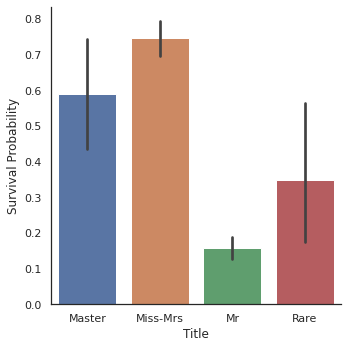

In [ ]:
g = sns.factorplot(x='Title', y='Survived', data=data, kind='bar')
g = g.set_xticklabels(["Master", "Miss-Mrs", "Mr", "Rare"])
g = g.set_ylabels("Survival Probability")

In [ ]:
data.drop(['Name'], axis=1, inplace=True)

## 5. Feature engineering
### 5-2. Family size
- 손님이 부모/자녀(Prach) 또는 형제/자매(SibSp)와 함께 탑승했다면 가족을 찾느라 대피가 늦어질 수도 있으므로, 가족의 규모가 생존 여부에 영향을 미칠 수도 있다고 추측된다.
- 이 가설을 확인하기 위해 Parch와 SibSp을 합하고 본인까지 1을 더하여 가족 구성원의 크기를 의미하는 Fsize 칼럼을 생성한다.
- 가족 구성원의 수가 5를 넘어가면서부터 생존 확률이 급격하게 낮아지는 것을 확인할 수 있다.



In [ ]:
data['Fsize'] = data['SibSp'] + data['Parch'] + 1

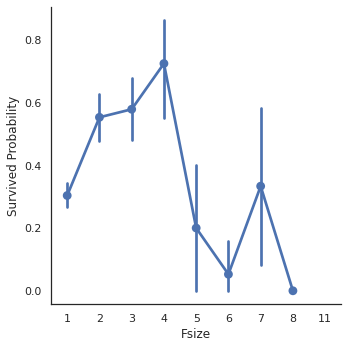

In [ ]:
g = sns.factorplot(x='Fsize', y='Survived', data=data)
g = g.set_ylabels("Survived Probability")

## 5. Feature engineering
### 5-2. Family size
- 따라서 가족 구성원의 수가 생존 여부를 추측하는데 중요한 역할을 한다고 판단된다.
- Fsize 칼럼을 [1명/2명/3~4명/5명이상] 4개의 카테고리로 나눠서 각각의 이름을 정하고, 그에 해당하면 1을 아니면 0을 갖는 칼럼을 생성한다.
- 그렇게 생성한 4개의 칼럼에 대해 생존 확률을 구하여 비교한다.
- 중소형 가족이 1인가족이나 대가족보다 생존 확률이 더 높게 나타난다.

In [ ]:
data['Single'] = data['Fsize'].map(lambda s: 1 if s==1 else 0)
data['SmallF'] = data['Fsize'].map(lambda s: 1 if s==2 else 0)
data['MedF'] = data['Fsize'].map(lambda s: 1 if 3<=s<=4 else 0)
data['LargeF'] = data['Fsize'].map(lambda s: 1 if s>=5 else 0)

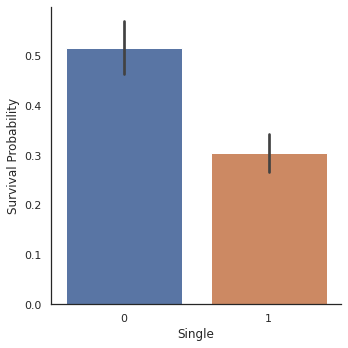

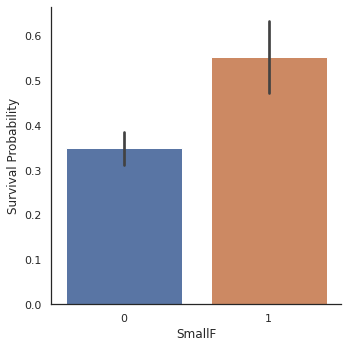

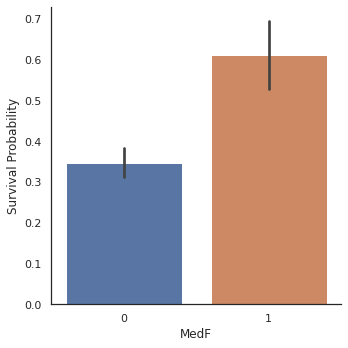

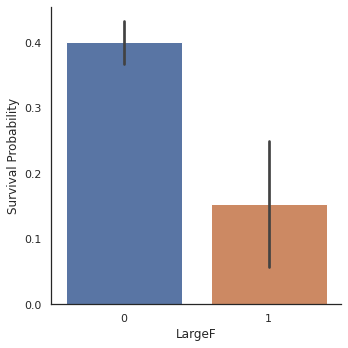

In [ ]:
g = sns.factorplot(x='Single', y='Survived', data=data, kind='bar')
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x='SmallF', y='Survived', data=data, kind='bar')
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x='MedF', y='Survived', data=data, kind='bar')
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x='LargeF', y='Survived', data=data, kind='bar')
g = g.set_ylabels("Survival Probability")

## 5. Feature engineering
- Title 칼럼에 대해 `pd.get_dummies( )`를 이용하여 원핫인코딩을 수행한다.
- Embarked 칼럼에 대해 `pd.get_dummies( )`를 이용하여 원핫인코딩을 수행한다. 각 카테고리의 이름 앞에 Em이 붙도록 칼럼을 생성한다.
- 여기까지 진행하면 데이터는 총 22개의 칼럼을 갖는다.

In [ ]:
data = pd.get_dummies(data, columns=['Title'])

In [ ]:
data = pd.get_dummies(data, columns=['Embarked'], prefix="Em")

In [ ]:
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.000,3,0,22.000,1,0,A/5 21171,1.981,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.000,1,1,38.000,1,0,PC 17599,4.267,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.000,3,1,26.000,0,0,STON/O2. 3101282,2.070,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.000,1,1,35.000,1,0,113803,3.972,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.000,3,0,35.000,0,0,373450,2.086,NaN,...,0,0,0,0,0,1,0,0,0,1


## 5. Feature engineering
### 5-3. Cabin
- Cabin 칼럼은 292개의 자료와 1007개의 결측치를 갖는다.
- 주어진 객실이 없는 손님의 Cabin 칼럼이 결측치를 갖는 것으로 추측된다.

In [ ]:
data['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [ ]:
data['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [ ]:
data['Cabin'].isnull().sum()

1007

In [ ]:
data['Cabin'][data['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

## 5. Feature engineering
### 5-3. Cabin
- Cabin 칼럼에 정확한 값을 갖는 자료에 대해서 객실 번호를 제외한 가장 맨 앞의 알파벳만 남기도록 칼럼을 변환한다.
- 결측치는 알파벳 'X'로 처리한다.
- 자료의 개수가 적으므로 서로 다른 객실을 가진 자료들에 대해서는 표준편차가 크고, 생존 확률도 비슷하여 비교하기가 어렵다.
- 하지만 객실이 없는 'X'에 비해서는 객실을 가졌을 때 생존 확률이 더 높게 나타난다는 것을 확인할 수 있다. 특히 B, C, D, E, F에서 두드러진다.
- Cabin 칼럼에 대해 `pd.get_dummies( )`를 이용하여 원핫인코딩을 수행한다. 각 카테고리의 이름 앞에 Cabin이 붙도록 칼럼을 생성한다.

In [ ]:
data['Cabin'] = pd.Series(i[0] if not pd.isnull(i) else 'X' for i in data['Cabin'])

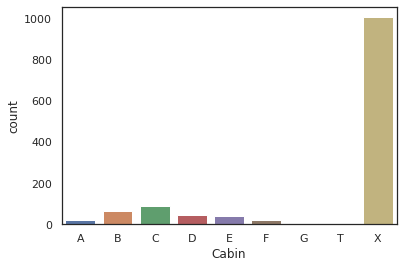

In [ ]:
g = sns.countplot(data['Cabin'], order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

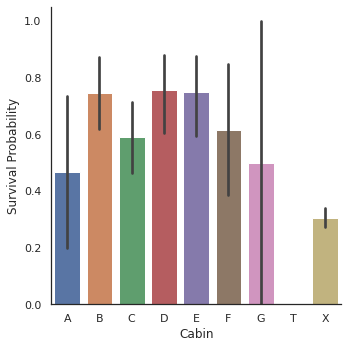

In [ ]:
g = sns.factorplot(x='Cabin', y='Survived', data=data, kind='bar', order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])
g = g.set_ylabels("Survival Probability")

In [ ]:
data = pd.get_dummies(data, columns=['Cabin'], prefix="Cabin")

## 5. Feature engineering
### 5-4. Ticket
- Ticket 칼럼에 같은 접두사를 사용하는 사람들은 같은 객실에 배정될 수 있다.
- 같은 객실의 사람들은 비슷한 좌석 등급과 생존 확률을 가질 것이라고 추측된다.
- 따라서 Ticket 칼럼 문자를 포함하는 자료에 대하여 문자인 접두사만 포함하도록 변환한 칼럼을 생성한다.
- 문자가 포함되지 않은 숫자형 자료는 'X'로 처리한다.
- Ticket 칼럼에 대해 `pd.get_dummies( )`를 이용하여 원핫인코딩을 수행한다. 각 카테고리의 이름 앞에 T가 붙도록 칼럼을 생성한다.

In [ ]:
data['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [ ]:
Ticket = []
for i in list(data.Ticket):
    if not i.isdigit(): # Ticket 칼럼에 문자를 포함한 행
        Ticket.append(i.replace(".", "").replace("/","").strip().split(" ")[0])
    else:
        Ticket.append("X")

In [ ]:
data['Ticket'] = Ticket
data['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [ ]:
data = pd.get_dummies(data, columns=['Ticket'], prefix="T")

## 5. Feature engineering
- 숫자형이지만 자료가 범주형의 의미를 갖는 Pclass 칼럼에 대해 카테고리형 변수로 변환한다.
- Pclass 칼럼에 대해 `pd.get_dummies( )`를 이용하여 원핫인코딩을 수행한다. 각 카테고리의 이름 앞에 Pc가 붙도록 칼럼을 생성한다.
- PassengerId 칼럼은 모델 예측에 영향을 미치지 않으므로 제거한다.
- 전처리를 마친 데이터는 총 67개의 칼럼을 갖는다.

In [ ]:
data['Pclass'] = data['Pclass'].astype('category')
data = pd.get_dummies(data, columns=['Pclass'], prefix="Pc")

In [ ]:
data.drop(labels=['PassengerId'], axis=1, inplace=True)

In [ ]:
data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.000,0,22.000,1,0,1.981,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.000,1,38.000,1,0,4.267,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.000,1,26.000,0,0,2.070,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.000,1,35.000,1,0,3.972,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.000,0,35.000,0,0,2.086,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## 6. Modeling
- 데이터를 다시 train data와 test data로 분할한다.
- 타겟 변수인 Survived 칼럼만을 포함하는 Y_train과 이 칼럼만을 제외한 X_train을 생성한다.

In [ ]:
train_len = len(train)

train = data[:train_len]
test = data[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

In [ ]:
train['Survived'] = train['Survived'].astype(int)

X_train = train.drop(labels=['Survived'], axis=1)
Y_train = train['Survived']

## 6. Modeling
### 6-1. Simple modeling
#### 1) Cross validate models
- 10개의 유명한 분류기를 이용하여 예측을 수행하고, stratified kfold cross validation을 이용하여 평균 정확도를 평가한다.
- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Multiple Layer Perceprton(neural network)
- KNN
- Logistic Regression
- Linear Discriminant Analysis

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [ ]:
kfold = StratifiedKFold(n_splits=10)

In [ ]:
random_state = 2
classifiers = []

classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, Y_train, scoring='accuracy', cv=kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [ ]:
cv_res = pd.DataFrame({"CrossValMeans": cv_means, "CrossValerrors": cv_std, 
                       "Algorithm": ['SVC', 'DecisionTree', 'AdaBoost', 'RandomForest', 'ExtraTrees', 'GradientBoosting', 
                                               'MultipleLayerPerceptron', 'KNeighbors', 'LogisticRegression', 'LinearDiscriminantAnalysis']})

In [ ]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.728,0.041,SVC
1,0.804,0.038,DecisionTree
2,0.801,0.049,AdaBoost
3,0.800,0.051,RandomForest
4,0.803,0.045,ExtraTrees
5,0.830,0.042,GradientBoosting
6,0.820,0.033,MultipleLayerPerceptron
7,0.796,0.038,KNeighbors
8,0.822,0.035,LogisticRegression
9,0.823,0.039,LinearDiscriminantAnalysis


## 6. Modeling
### 6-1. Simple modeling
#### 1) Cross validate models
- Cross Validation의 평균과 표준편차를 구하여 데이터프레임을 생성하고, bar그래프를 그려 정확도를 비교할 수 있다.
- **SVC, AdaBoost, RandomForest , ExtraTrees and the GradientBoosting** 분류기를 사용하기로 결정하여 앙상블 모델링을 수행한다.

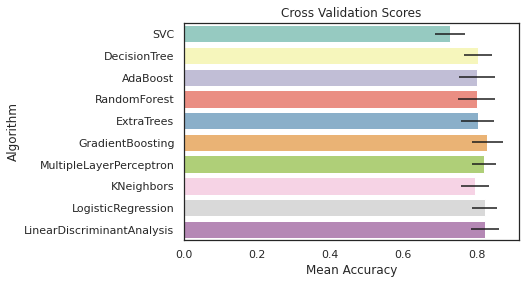

In [ ]:
g = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Set3', orient='h',**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross Validation Scores")

## 6. Modeling
### 6-1. Simple modeling
#### 2) Hyperparameter tunning for best models
- SVC, AdaBoost, RandomForest , ExtraTrees and the GradientBoosting 모델에 GridSearch를 수행한다.

In [ ]:
# AdaBoost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)
ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [ ]:
ada_best

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy'),
                   learning_rate=0.3, n_estimators=2, random_state=7)

In [ ]:
gsadaDTC.best_score_

0.8275536261491316

In [ ]:
# ExtraTrees 
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)
ExtC_best = gsExtC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [ ]:
ExtC_best

ExtraTreesClassifier(max_features=3, min_samples_leaf=3, min_samples_split=10,
                     n_estimators=300)

In [ ]:
gsExtC.best_score_

0.8320224719101124

In [ ]:
# RandomForest
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)
RFC_best = gsRFC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [ ]:
RFC_best

RandomForestClassifier(bootstrap=False, max_features=3, min_samples_leaf=3,
                       n_estimators=300)

In [ ]:
gsRFC.best_score_

0.8354443309499489

In [ ]:
# GradientBoosting
GBC = GradientBoostingClassifier()

gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)
GBC_best = gsGBC.best_estimator_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


In [ ]:
GBC_best

GradientBoostingClassifier(max_depth=8, max_features=0.3, min_samples_leaf=100,
                           n_estimators=300)

In [ ]:
gsGBC.best_score_

0.8320224719101124

In [ ]:
# SVC 
SVMC = SVC(probability=True)

svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)
SVMC_best = gsSVMC.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


In [ ]:
SVMC_best

SVC(C=10, gamma=0.01, probability=True)

In [ ]:
gsSVMC.best_score_

0.8331332992849847

## 6. Modeling
### 6-1. Simple modeling
#### 3) Plot learning curves
- 학습 곡선은 훈련 세트에 대한 과적합 효과와 훈련 크기가 정확도에 미치는 영향을 보는 좋은 방법이다.
- 각 분류기별로 학습 곡선을 그리고 결과를 확인한다.
---
- GradientBoosting과 AdaBoost 분류기는 훈련 세트에 과적합하는 경향이 있다.
- 교차 검증 곡선이 증가함에 따라 GradientBoosting과 Adaboost 분류기는 더 많은 훈련 세트를 수행한다면 성능이 향상될 것이다.
- SVC와 ExtraTrees 분류기는 훈련과 교차 검증 곡선이 서로 가깝기 때문에 예측을 더 잘 일반화하는 것으로 보인다.

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    # Generate a simple plot of the test and training learning curve
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.legend(loc='best')
    return plt

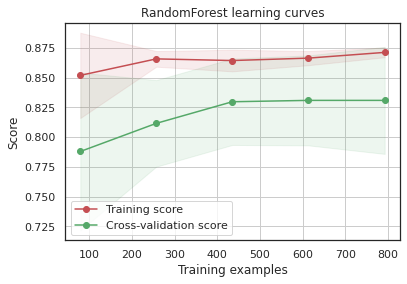

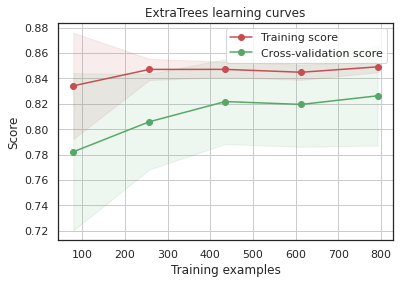

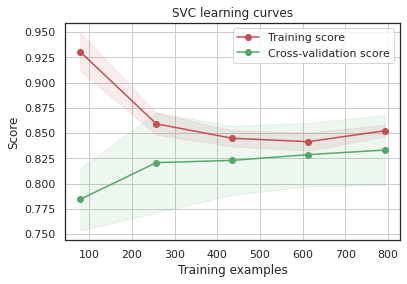

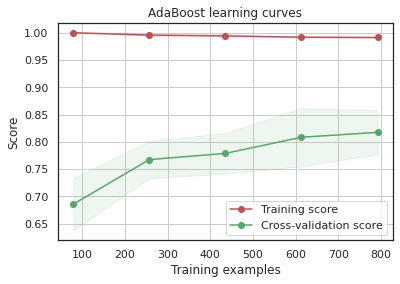

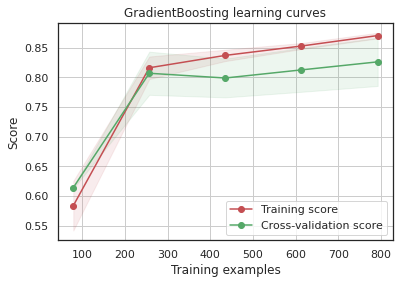

In [ ]:
g = plot_learning_curve(estimator=gsRFC.best_estimator_, title="RandomForest learning curves", X=X_train, y=Y_train, cv=kfold)
g = plot_learning_curve(estimator=gsExtC.best_estimator_, title="ExtraTrees learning curves", X=X_train, y=Y_train, cv=kfold)
g = plot_learning_curve(estimator=gsSVMC.best_estimator_, title="SVC learning curves", X=X_train, y=Y_train, cv=kfold)
g = plot_learning_curve(estimator=gsadaDTC.best_estimator_, title="AdaBoost learning curves", X=X_train, y=Y_train, cv=kfold)
g = plot_learning_curve(estimator=gsGBC.best_estimator_, title="GradientBoosting learning curves", X=X_train, y=Y_train, cv=kfold)

## 6. Modeling
### 6-1. Simple modeling
#### 4) Feature importance of tree based classifiers
- 승객 생존 예측을 위한 가장 유용한 기능을 보기 위해 4개의 트리 기반 분류기에 대한 feature importance를 알아본다.
- 4개의 분류기는 각각 다른 상위권의 특성 중요도를 가진다. 즉 분류기의 예측이 같은 피처에 의존하지 않는다.
- 그럼에도 공통적으로 상위권에 속하는 **Fare, Title_2, Age, Sex** 등의 몇개의 피처는 분류를 예측하는데 어떤 동일한 영향을 미친다고 볼 수 있다.
- Title_2 칼럼은 Name에 Mrs/Mlle/Mme/Miss/Ms 를 가지는 것을 의미하며, 이는 Sex 칼럼과 강한 상관성이 있어 보인다.
- 몇 개의 피처에 대해 다음과 같은 해석을 할 수 있다.
 - Pc_1, Pc_2, Pc_3 및 Fare은 승객의 일반적인 사회적 지위를 의미한다.
 - Sex, Title_2(Mrs/Mle/Mme/Miss/Ms) 및 Title_3(Mr)은 성별을 의미한다.
 - 연령과 Title_1(Master)은 승객의 나이를 의미한다.
 - Fsize, LargeF, MedF, Single은 승객 가족의 크기를 의미한다.
- 4개의 분류기의 특성 중요도에 따르면, 생존 여부에 대한 예측은 보트 내에서의 위치보다 **연령, 성별, 가족 규모, 탑승자의 사회적 지위**와 더 관련이 있는 것으로 보인다.

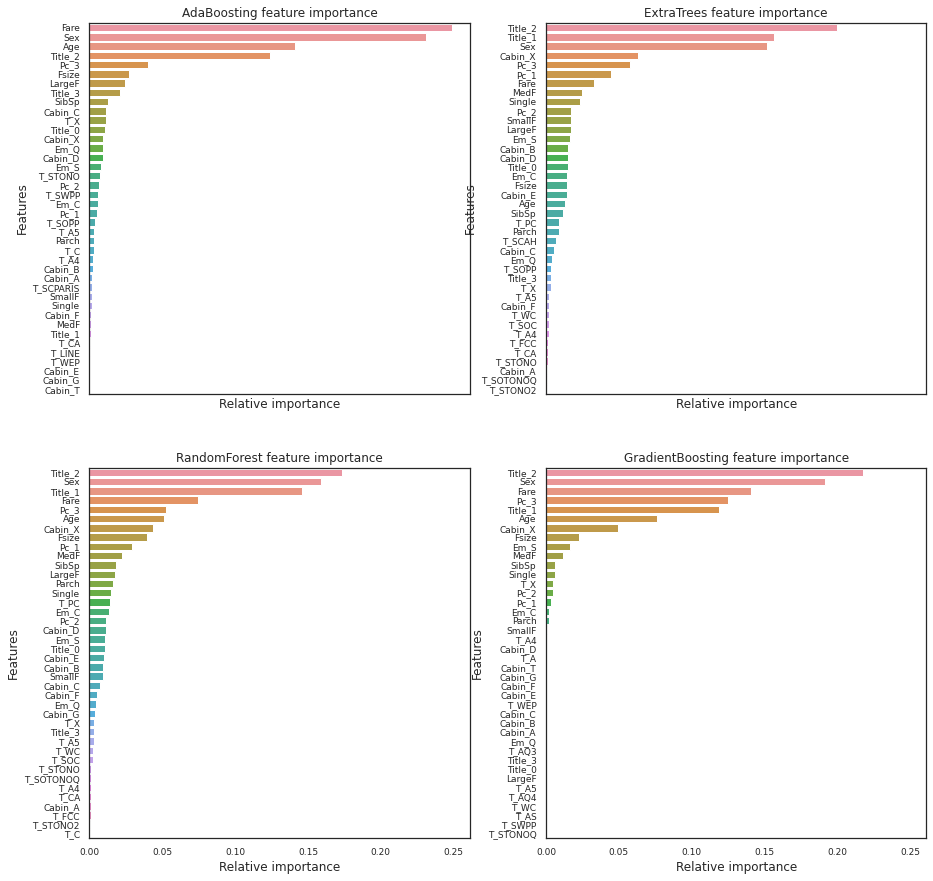

In [ ]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', figsize=(15, 15))

names_classifiers = [("AdaBoosting", ada_best), ("ExtraTrees", ExtC_best), ("RandomForest", RFC_best), ("GradientBoosting", GBC_best)]
nclassifier = 0

for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40], x=classifier.feature_importances_[indices][:40], orient='h', ax=axes[row][col])
        g.set_xlabel("Relative importance", fontsize=12)
        g.set_ylabel("Features", fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name+" feature importance")
        nclassifier += 1

## 6. Modeling
### 6-1. Simple modeling
#### 4) Feature importance of tree based classifiers
- 학습한 모델을 이용하여 test data 대해 예측을 진행하고, 새로운 DataFrame을 생성한다.
- 각 예측 결과에 대해 히트맵을 그려서 상관관계를 확인한다.
- AdaBoost의 경우를 제외하고는 5개 분류기의 예측이 꽤 비슷해 보인다.
- 5개의 분류기는 거의 동일한 예측을 제공하지만 약간의 차이가 있다. 이러한 차이는 앙상블 투표를 고려하기에 충분하다고 판단된다.

In [ ]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name='RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name='ExtC')
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name='SVC')
test_Survived_AdaC = pd.Series(ada_best.predict(test), name='Ada')
test_Survived_GBC = pd.Series(GBC_best.predict(test), name='GBC')

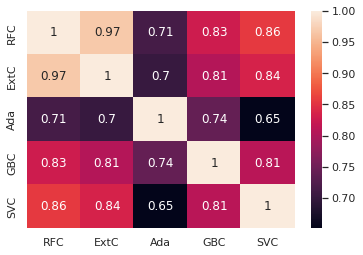

In [ ]:
ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC, test_Survived_GBC, test_Survived_SVMC], axis=1)

g = sns.heatmap(ensemble_results.corr(), annot=True)

## 6. Modeling
### 6-2. Ensemble modeling
#### 1) Combinig models
- 5개의 분류기를 이용한 예측을 결합하기 위해 **`voting classifier`**를 사용한다.
- **각 투표의 확률을 고려**하기 위해 voting parameter에 **'soft'** 옵션을 사용했다.

In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac', ada_best), ('gbc', GBC_best)], 
                                                 voting='soft', n_jobs=-1)
votingC = votingC.fit(X_train, Y_train)

## 6. Modeling
### 6-3. Prediction
#### 1) Predict and Submit results
- test data에 대해 예측을 수행하고 결과를 저장한다.
- submission data에 예측 결과를 입력한다.

In [ ]:
test_Survived = pd.Series(votingC.predict(test))

In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/ESAA/data/gender_submission.csv")
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
submission['Survived'] = test_Survived
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
